In [53]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.applications import EfficientNetB7
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History

import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import cv2

In [54]:
from pathlib import Path
import os
import seaborn as sns
from typing import Iterator, List, Union, Tuple
from datetime import datetime
from sklearn.model_selection import train_test_split

In [55]:
import pandas as pd

In [56]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [57]:
# # req_country = 'Malawi'
# def data_extraction(req_country): 
#     processed_path = Path(str(Path(os.getcwd()).parent.absolute()) + '/ProcessedHistograms')
#     country_list = sorted(processed_path.glob('*'))
#     train_x, train_y, test_x, test_y, val_x, val_y = [], [], [], [], [], []
#     data_array = []
#     df_label = get_label_data()   
#     for country in country_list:
#         if req_country in str(country):
#             break
        
#     data_list = sorted(country.glob('*.npy'))
#     country_nme = str(country).split('\\')[-1]
#     country_label = df_label.loc[country_nme]
#     for i in data_list:
#         year = str(i).split('_')[-1][:4]
#         data_array = np.load(str(i.absolute()))
#         data_array = cv2.resize(data_array, (224, 224))
#         hist_3 = np.zeros((224,224, 3))
#         hist_3[:,:,0] = data_array 
#         hist_3[:,:,1] = data_array
#         hist_3[:,:,2] = data_array
#         if year < '2014':
#             train_x.append(hist_3)
#             train_y.append(country_label[year])
#         elif year < '2015':
#             val_x.append(hist_3)
#             val_y.append(country_label[year])
#         else:
#             test_x.append(hist_3)
#             test_y.append(country_label[year])

#     return train_x, train_y, test_x, test_y, val_x, val_y


# def get_label_data() -> pd.DataFrame:
#     label_path = str(Path(os.getcwd()).parent.absolute()) + '/Yield_Data/yield.csv'
#     df = pd.read_csv(label_path)
#     df = df.set_index(['Country Name'])
#     df = df.drop(['Country Code','Indicator Name', 'Indicator Code', '2019','2020', '2021'], axis=1)
#     return df

In [58]:
# req_country = 'Malawi'
def data_extraction(): 
    processed_path = Path(str(Path(os.getcwd()).parent.absolute())+'/PR_Sandbox/data_country_folders')
    country_list = sorted(processed_path.glob('*'))
    train_x, train_y, test_x, test_y, val_x, val_y = [], [], [], [], [], []
    data_array = []
    df_label = get_label_data()   
    for country in country_list:        
        data_list = sorted(country.glob('*.npy'))
        country_nme = str(country).split('\\')[-1]
        country_label = df_label.loc[country_nme]
        for i in data_list:
            year = str(i).split('_')[-1][:4]
            data_array = np.load(str(i.absolute()))
            data_array = cv2.resize(data_array, (224, 224))
            hist_3 = np.zeros((224,224, 3))
            hist_3[:,:,0] = data_array 
            hist_3[:,:,1] = data_array
            hist_3[:,:,2] = data_array
            if year < '2014':
                train_x.append(hist_3)
                train_y.append(country_label[year])
            elif year < '2015':
                val_x.append(hist_3)
                val_y.append(country_label[year])
            else:
                test_x.append(hist_3)
                test_y.append(country_label[year])

    return train_x, train_y, test_x, test_y, val_x, val_y


def get_label_data() -> pd.DataFrame:
    label_path = str(Path(os.getcwd()).parent.absolute()) + '/Yield_Data/all_country_crop_yield_tons_per_hectare.csv'
    df = pd.read_csv(label_path)
    df = df.set_index(['Country Name'])
#     df = df.drop(['Country Code','Indicator Name', 'Indicator Code', '2019','2020', '2021'], axis=1)
    return df

In [59]:
# processed_path = Path(str(Path(os.getcwd()).parent.absolute())+'/PR_Sandbox/data_country_folders')
# country_list = sorted(processed_path.glob('*'))
# x = get_label_data()
# x.head()

In [60]:
# for country in country_list:
#     print(str(country).split('\\')[-1])
# x1['2004']

In [61]:
x_train,y_train,x_test,y_test, x_val, y_val = data_extraction()
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)


In [62]:
# df = pd.DataFrame.from_records(x_train)

In [63]:
# df.iloc[0,0].shape

In [64]:
# y_train

In [65]:

    
def get_mean_baseline(y_train, y_test):
    df_train = pd.DataFrame(y_train, columns=['yield'])
    df_val = pd.DataFrame(y_test, columns=['yield'])
    y_hat = df_train['yield'].mean()
    df_val['y_hat']=y_hat
    mae = MeanAbsoluteError()
    mae = mae(df_val["yield"], df_val["y_hat"]).numpy()  
    mape = MeanAbsolutePercentageError()
    mape = mape(df_val["yield"], df_val["y_hat"]).numpy()
    print('Mean Absolute Error: ', mae)
    print("mean baseline MAPE: ", mape)
    return mape

def create_generators(x_train,y_train,x_test,y_test, x_val, y_val):
    train_generator = ImageDataGenerator() 
    
    validation_generator = ImageDataGenerator()     
    test_generator = ImageDataGenerator()
    
    train_generator = train_generator.flow(
        x_train,
        y_train,
        batch_size=2, # increase or decrease to fit your GPU
    )

    validation_generator = validation_generator.flow(
        x_val,
        y_val,
        batch_size=1,
    )
    test_generator = test_generator.flow(
        x_test,
        y_test,
        batch_size=1,
    )
    return train_generator, validation_generator, test_generator
    

In [66]:
def run_model(
    model_name: str,
    model_function: Model,
    lr: float,
    train_generator: Iterator,
    validation_generator: Iterator,
    test_generator: Iterator,
) -> History:
    
    callbacks = get_callbacks(model_name)
    model = model_function
    model.summary()
    plot_model(model, to_file=model_name + ".jpg", show_shapes=True)

    radam = tfa.optimizers.RectifiedAdam(learning_rate=lr)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    optimizer = ranger

    model.compile(
        optimizer=optimizer, loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()]
    )
    history = model.fit(
        train_generator,
        epochs=100,
        validation_data=validation_generator,
        callbacks=callbacks,
        workers=10, # adjust this according to the number of CPU cores of your machine
    )

    model.evaluate(
        test_generator,
        callbacks=callbacks,
    )
    return history

In [67]:
def get_callbacks(model_name: str) -> List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]:
    """Accepts the model name as a string and returns multiple callbacks for training the keras model.
    Parameters
    ----------
    model_name : str
        The name of the model as a string.
    Returns
    -------
    List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]
        A list of multiple keras callbacks.
    """
    logdir = (
        "logs/scalars/" + model_name + "_" + datetime.now().strftime("%Y%m%d-%H%M%S")
    )  # create a folder for each model.
    tensorboard_callback = TensorBoard(log_dir=logdir)
    # use tensorboard --logdir logs/scalars in your command line to startup tensorboard with the correct logs

    early_stopping_callback = EarlyStopping(
        monitor="val_mean_absolute_percentage_error",
        min_delta=0.1,  # model should improve by at least 1%
        patience=50,  # amount of epochs  with improvements worse than 1% until the model stops
        verbose=2,
        mode="min",
        restore_best_weights=True,  # restore the best model with the lowest validation error
    )

    model_checkpoint_callback = ModelCheckpoint(
        "./data/models/" + model_name + ".h5",
        monitor="val_mean_absolute_percentage_error",
        verbose=0,
        save_best_only=True,  # save the best model
        mode="min",
        save_freq="epoch",  # save every epoch
    )  # saving eff_net takes quite a bit of time
    return [tensorboard_callback, early_stopping_callback, model_checkpoint_callback]

In [68]:
def small_cnn() -> Sequential:
    """A very small custom convolutional neural network with image input dimensions of 224x224x3.
    Returns
    """
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1))

    return model

In [69]:
def adapt_efficient_net() -> Model:
   
    inputs = layers.Input(shape=(224, 224, 3))  # input shapes of the images should always be 224x224x3 with EfficientNetB0
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights=None)
#     # Freeze the pretrained weights
#     model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(1, name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")

    return model

In [79]:
def plot_results(model_history_small_cnn: History, model_history_eff_net: History, mean_baseline: float):
    """This function uses seaborn with matplotlib to plot the trainig and validation losses of both input models in an
    sns.relplot(). The mean baseline is plotted as a horizontal red dotted line.

    Parameters
    ----------
    model_history_small_cnn : History
        keras History object of the model.fit() method.
    model_history_eff_net : History
        keras History object of the model.fit() method.
    mean_baseline : float
        Result of the get_mean_baseline() function.
    """

    # create a dictionary for each model history and loss type
    dict1 = {
        "MAPE": model_history_small_cnn.history["mean_absolute_percentage_error"],
        "type": "training",
        "model": "small_cnn",
    }
    dict2 = {
        "MAPE": model_history_small_cnn.history["val_mean_absolute_percentage_error"],
        "type": "validation",
        "model": "small_cnn",
    }
    dict3 = {
        "MAPE": model_history_eff_net.history["mean_absolute_percentage_error"],
        "type": "training",
        "model": "eff_net",
    }
    dict4 = {
        "MAPE": model_history_eff_net.history["val_mean_absolute_percentage_error"],
        "type": "validation",
        "model": "eff_net",
    }

    # convert the dicts to pd.Series and concat them to a pd.DataFrame in the long format
    s1 = pd.DataFrame(dict1)
    s2 = pd.DataFrame(dict2)
    s3 = pd.DataFrame(dict3)
    s4 = pd.DataFrame(dict4)
    df = pd.concat([s1, s2, s3, s4], axis=0).reset_index()
    grid = sns.relplot(data=df, x=df["index"], y="MAPE", hue="model", col="type", kind="line", legend=False)
    grid.set(ylim=(20, 200))  # set the y-axis limit
    for ax in grid.axes.flat:
        ax.axhline(
            y=mean_baseline, color="lightcoral", linestyle="dashed"
        )  # add a mean baseline horizontal bar to each plot
        ax.set(xlabel="Epoch")
    labels = ["small_cnn", "eff_net", "mean_baseline"]  # custom labels for the plot

    plt.legend(labels=labels)
    plt.savefig("training_validation.png")
    plt.show()
    return df

Mean Absolute Error:  0.5369990468025208
mean baseline MAPE:  64.52413940429688
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 173056)            0         
__________________________________________

144/144 [==============================] - 33s 232ms/step - loss: 0.1467 - mean_absolute_error: 0.1467 - mean_absolute_percentage_error: 14.6614 - val_loss: 0.2858 - val_mean_absolute_error: 0.2858 - val_mean_absolute_percentage_error: 30.0471
Epoch 27/100
144/144 [==============================] - 34s 233ms/step - loss: 0.1463 - mean_absolute_error: 0.1463 - mean_absolute_percentage_error: 14.3690 - val_loss: 0.3139 - val_mean_absolute_error: 0.3139 - val_mean_absolute_percentage_error: 33.4905
Epoch 28/100
144/144 [==============================] - 34s 233ms/step - loss: 0.1413 - mean_absolute_error: 0.1413 - mean_absolute_percentage_error: 14.5832 - val_loss: 0.2555 - val_mean_absolute_error: 0.2555 - val_mean_absolute_percentage_error: 24.3939
Epoch 29/100
144/144 [==============================] - 35s 243ms/step - loss: 0.1396 - mean_absolute_error: 0.1396 - mean_absolute_percentage_error: 14.7858 - val_loss: 0.2409 - val_mean_absolute_error: 0.2409 - val_mean_absolute_percentage_

Epoch 58/100
144/144 [==============================] - 33s 229ms/step - loss: 0.0993 - mean_absolute_error: 0.0993 - mean_absolute_percentage_error: 9.9836 - val_loss: 0.3121 - val_mean_absolute_error: 0.3121 - val_mean_absolute_percentage_error: 26.3016
Epoch 59/100
144/144 [==============================] - 33s 231ms/step - loss: 0.1039 - mean_absolute_error: 0.1039 - mean_absolute_percentage_error: 9.9641 - val_loss: 0.3166 - val_mean_absolute_error: 0.3166 - val_mean_absolute_percentage_error: 27.8992
Epoch 60/100
144/144 [==============================] - 33s 228ms/step - loss: 0.0951 - mean_absolute_error: 0.0951 - mean_absolute_percentage_error: 9.7396 - val_loss: 0.2797 - val_mean_absolute_error: 0.2797 - val_mean_absolute_percentage_error: 24.2476
Epoch 61/100
144/144 [==============================] - 33s 230ms/step - loss: 0.0919 - mean_absolute_error: 0.0919 - mean_absolute_percentage_error: 9.4291 - val_loss: 0.2442 - val_mean_absolute_error: 0.2442 - val_mean_absolute_pe

C:\Users\talha\anaconda3\envs\EffNet\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


144/144 [==============================] - 93s 414ms/step - loss: 3.1847 - mean_absolute_error: 3.1847 - mean_absolute_percentage_error: 331.5122 - val_loss: 1649.0991 - val_mean_absolute_error: 1649.0991 - val_mean_absolute_percentage_error: 181773.9844
Epoch 2/100
144/144 [==============================] - 54s 372ms/step - loss: 2.8866 - mean_absolute_error: 2.8866 - mean_absolute_percentage_error: 330.2971 - val_loss: 2117.0901 - val_mean_absolute_error: 2117.0901 - val_mean_absolute_percentage_error: 232706.8906
Epoch 3/100
144/144 [==============================] - 51s 354ms/step - loss: 2.9967 - mean_absolute_error: 2.9967 - mean_absolute_percentage_error: 336.2695 - val_loss: 133864.4375 - val_mean_absolute_error: 133864.4375 - val_mean_absolute_percentage_error: 14595347.0000
Epoch 4/100
144/144 [==============================] - 51s 353ms/step - loss: 3.5132 - mean_absolute_error: 3.5132 - mean_absolute_percentage_error: 411.0905 - val_loss: 6.5826 - val_mean_absolute_error: 6

Epoch 33/100
144/144 [==============================] - 56s 389ms/step - loss: 0.6251 - mean_absolute_error: 0.6251 - mean_absolute_percentage_error: 72.6814 - val_loss: 0.5342 - val_mean_absolute_error: 0.5342 - val_mean_absolute_percentage_error: 60.7830
Epoch 34/100
144/144 [==============================] - 57s 397ms/step - loss: 0.5972 - mean_absolute_error: 0.5972 - mean_absolute_percentage_error: 73.7973 - val_loss: 3.2961 - val_mean_absolute_error: 3.2961 - val_mean_absolute_percentage_error: 317.0827
Epoch 35/100
144/144 [==============================] - 57s 397ms/step - loss: 0.6142 - mean_absolute_error: 0.6142 - mean_absolute_percentage_error: 70.9751 - val_loss: 1.4216 - val_mean_absolute_error: 1.4216 - val_mean_absolute_percentage_error: 203.8045
Epoch 36/100
144/144 [==============================] - 56s 389ms/step - loss: 0.5771 - mean_absolute_error: 0.5771 - mean_absolute_percentage_error: 65.0794 - val_loss: 0.5143 - val_mean_absolute_error: 0.5143 - val_mean_absol

Epoch 65/100
144/144 [==============================] - 49s 343ms/step - loss: 0.7354 - mean_absolute_error: 0.7354 - mean_absolute_percentage_error: 85.9245 - val_loss: 0.6045 - val_mean_absolute_error: 0.6045 - val_mean_absolute_percentage_error: 58.5522
Epoch 66/100
144/144 [==============================] - 52s 364ms/step - loss: 0.6364 - mean_absolute_error: 0.6364 - mean_absolute_percentage_error: 74.3811 - val_loss: 0.5473 - val_mean_absolute_error: 0.5473 - val_mean_absolute_percentage_error: 62.9613
Epoch 67/100
144/144 [==============================] - 57s 394ms/step - loss: 0.5989 - mean_absolute_error: 0.5989 - mean_absolute_percentage_error: 72.3699 - val_loss: 0.5545 - val_mean_absolute_error: 0.5545 - val_mean_absolute_percentage_error: 62.7383
Epoch 68/100
144/144 [==============================] - 57s 394ms/step - loss: 0.6167 - mean_absolute_error: 0.6167 - mean_absolute_percentage_error: 71.4960 - val_loss: 0.5299 - val_mean_absolute_error: 0.5299 - val_mean_absolut

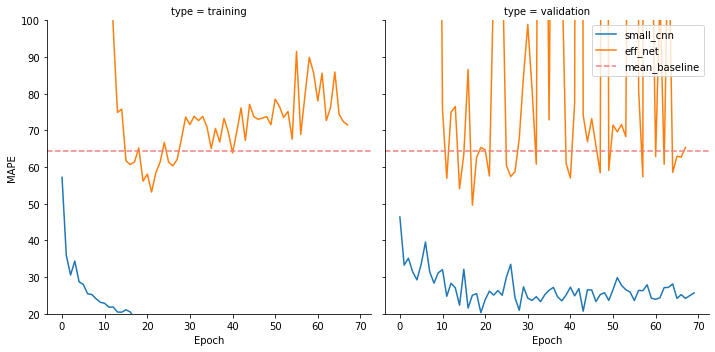

In [71]:
# def run(y_train, y_val):
mean_baseline = get_mean_baseline(y_train, y_val)
train_generator, validation_generator, test_generator = create_generators(x_train,y_train,x_test,y_test, x_val, y_val)
small_cnn_history = run_model(
    model_name="small_cnn",
    model_function=small_cnn(),
    lr=0.001,
    train_generator=train_generator,
    validation_generator=validation_generator,
    test_generator=test_generator,
)
eff_net_history = run_model(
    model_name="eff_net",
    model_function=adapt_efficient_net(),
    lr=0.05,
    train_generator=train_generator,
    validation_generator=validation_generator,
    test_generator=test_generator,
)


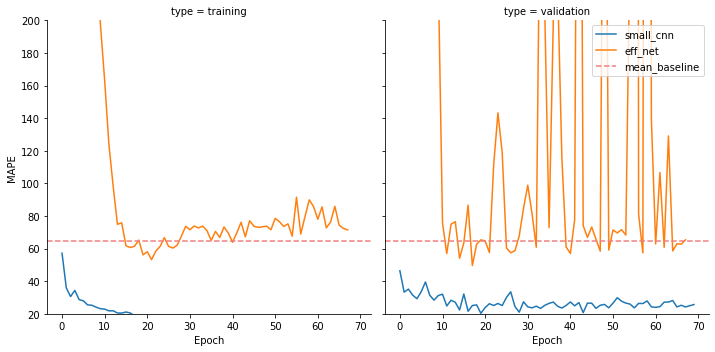

In [80]:
df = plot_results(small_cnn_history, eff_net_history, mean_baseline)

In [78]:
df

,index,MAPE,type,model
0,0,57.213432,training,small_cnn
1,1,35.907005,training,small_cnn
2,2,30.581734,training,small_cnn
3,3,34.371387,training,small_cnn
4,4,28.724575,training,small_cnn
...,...,...,...,...
271,63,129.125595,validation,eff_net
272,64,58.552170,validation,eff_net
273,65,62.961288,validation,eff_net
274,66,62.738255,validation,eff_net


In [86]:
(df['MAPE'].where(df['model']=='eff_net').where(df['type']=='validation')).min()

49.592594146728516

In [87]:
(df['MAPE'].where(df['model']=='eff_net').where(df['type']=='training')).min()

53.202880859375

In [88]:
(df['MAPE'].where(df['model']=='small_cnn').where(df['type']=='validation')).min()

20.30997085571289

In [89]:
(df['MAPE'].where(df['model']=='small_cnn').where(df['type']=='training')).min()

9.087663650512695